# Notebook 1 - Introduction to pyiron
This is a short introduction how to use pyiron for atomistic simulation. Starting with molecular dynamics calculation for interatomic potentials using [LAMMPS](https://lammps.sandia.gov) followed by DFT calculation using the opensource DFT code [S/PHI/nX](https://sxrepo.mpie.de) developed at the Max Planck Institut für Eisenfoschung. The focus of this first session is to get familiar with pyiron from a user perspective. More advanced workflows, the up-scaling and publishing of new workflows as well as the implementation of new simulation codes are going to be explained in the following sessions.

## Installation 
As affiliated project of the [numfocus foundation](https://numfocus.org) pyiron promotes open science principles in the materials science community. [Conda-Forge](https://conda-forge.org) is used as central package manager with over [100+ materials science specific simulation codes and tools](https://github.com/jan-janssen/conda-forge-contribution). So you can install pyiron, all required dependencies and many other tools with a single line: 

```
conda install -c conda-forge pyiron
```

For more advanced installation options, the configuration of commercial simulation codes, the connection to HPC computing resources like the queuing system or other installation options the reader is referred to the pyiron [installation documentation](https://pyiron.readthedocs.io/en/latest/source/installation.html). Alternatively this tutorial can also be executed directly in the webbrowser by using the [mybinder environment](https://mybinder.org). 

## Getting started
Moving away from the classical terminal pyiron is designed to integrate in the [jupyter interactive computing environment](https://jupyter.org). It should reduce the technical complexity and enable the scientist to focus on the scientific challenges. This is achieved by an abstract class of pyiron objects, which are explained in more detail in the corresponding [publication](https://www.sciencedirect.com/science/article/pii/S0927025618304786). Therefore pyiron is paritcularly suitable for rapid prototyping of simulation protocols and up-scaling those simulation protocols to the high-throughput scale.

To start using pyiron only a single import is required. The `Project` class is imported and a new project named `demonstration` is created. To execute the cell below use `shift` plus `enter`:

In [1]:
from pyiron_atomistics import Project
pr = Project("demonstration")

The `Project` object represents a folder on the file system, which is familiar to the user and allows the user to structure their simulation in a flexible way: 

In [2]:
pr.path

'/home/jovyan/demonstration/'

Beyond the filesystem, the `Project` object is also connected to an `SQL` database to track simulations executed with pyiron, their relationship and create other objects. 

## Atomistic Structures
Rather than developing a separate structure class, pyiron is based on the `ASE` structure class and extends it for interactive development when necessary. The `structure` object is created from the `Project` object using auto completion (tab-completion) to minimize the commands the user has to type: 

In [3]:
structure = pr.create.structure.ase.bulk("Fe")

The `ASE` database of bulk structures is used to determine that iron is bcc and select an initial guess for the lattice constant of `2.87`Å. The atomistic structure object `structure` can then be printed in the browser using: 

In [4]:
structure

Fe: [0. 0. 0.]
tags: 
    indices: [0]
pbc: [ True  True  True]
cell: 
Cell([[-1.435, 1.435, 1.435], [1.435, -1.435, 1.435], [1.435, 1.435, -1.435]])

Or alternatively it can be visualised using [NGLview](http://nglviewer.org/#nglview): 

In [5]:
structure.plot3d()

NGLWidget()

While visualising a single atom is not very helpful, a quick look at a larger structure can help to prevent wasting computing resources, for example when two atoms are too close. The `ASE` structure object behaves like a numpy array so here only a few simple manipulations are demonstrated. For a more detailed introduction to the `ASE` structure class the reader is referred to their [documentation](https://wiki.fysik.dtu.dk/ase/). 

Create a cubic fcc iron structure with a lattice constant of `3.6`Å:

In [6]:
structure_fcc = pr.create.structure.ase.bulk("Fe", crystalstructure="fcc", a=3.6, cubic=True)
structure_fcc

Fe: [0. 0. 0.]
Fe: [0.  1.8 1.8]
Fe: [1.8 0.  1.8]
Fe: [1.8 1.8 0. ]
tags: 
    indices: [0 0 0 0]
pbc: [ True  True  True]
cell: 
Cell([3.6, 3.6, 3.6])

Remove the first atom and replace the last atom with a carbon atom. Afterwards repeat the atomistic structure once in each direction. Finally visualise the resulting structure: 

In [7]:
del structure_fcc[0]
structure_fcc[-1] = "C"
structure_fcc_repeated = structure_fcc.repeat([2,2,2])
structure_fcc_repeated.plot3d()

NGLWidget()

## Molecular dynamics calculation
After the creation of the atomistic structure, the [LAMMPS](https://lammps.sandia.gov) molecular dynamics code is used in combination with the [NIST database for interatomic potentials](https://www.ctcms.nist.gov/potentials/) to calculate a molecular dynamics trajectory at a temperature of `500`K. Again the `Project` object is used to create the job object: 

In [8]:
job_lmp = pr.create.job.Lammps(job_name="lmp_md")

For the simulation we create a new `bcc` structure object and repeat it again once in each direction: 

In [9]:
fe_bcc = pr.create.structure.ase.bulk("Fe", cubic=True)
fe_bcc_repeated = fe_bcc.repeat([2,2,2])

Once the structure is assigned pyiron can automatically preselect all interatomic potentials which have an interaction for iron defined:

In [10]:
job_lmp.structure = fe_bcc_repeated
job_lmp.view_potentials()

,Config,Filename,Model,Name,Species,Citations
41,"[pair_style eam/fs\n, pair_coeff * * Fe.eam.fs...",[potential_LAMMPS/1997--Ackland-G-J--Fe--LAMMP...,NISTiprpy,1997--Ackland-G-J--Fe--LAMMPS--ipr1,[Fe],[{'Ackland_1997': {'title': 'Computer simulati...
47,"[pair_style eam\n, pair_coeff 1 1 Fe_MeyerEnte...",[potential_LAMMPS/1998--Meyer-R--Fe--LAMMPS--i...,NISTiprpy,1998--Meyer-R--Fe--LAMMPS--ipr1,[Fe],[{'Meyer_1998': {'title': 'Martensite-austenit...
55,"[pair_style meam\n, pair_coeff * * library.mea...",[potential_LAMMPS/2001--Lee-B-J--Fe--LAMMPS--i...,NISTiprpy,2001--Lee-B-J--Fe--LAMMPS--ipr1,[Fe],[{'Lee_2001': {'title': 'Second nearest-neighb...
56,"[pair_style meam\n, pair_coeff * * library.mea...",[potential_LAMMPS/2001--Lee-B-J--Fe-Cr--LAMMPS...,NISTiprpy,2001--Lee-B-J--Fe-Cr--LAMMPS--ipr1,"[Fe, Cr]",[{'Lee_2001': {'title': 'A semi-empirical atom...
78,"[pair_style eam/fs\n, pair_coeff * * Fe_2.eam....",[potential_LAMMPS/2003--Mendelev-M-I--Fe-2--LA...,NISTiprpy,2003--Mendelev-M-I--Fe-2--LAMMPS--ipr3,[Fe],[{'Mendelev_2003': {'title': 'Development of n...
...,...,...,...,...,...,...
949,[pair_style kim Sim_LAMMPS_MEAM_KimJungLee_200...,[],OPENKIM,Sim_LAMMPS_MEAM_KimJungLee_2009_FeTiC__SM_5310...,"[Fe, Ti, C]",[{'Hyun-Kyu_2009': {'title': 'Modified embedde...
953,[pair_style kim Sim_LAMMPS_MEAM_LiyanageKimHou...,[],OPENKIM,Sim_LAMMPS_MEAM_LiyanageKimHouze_2014_FeC__SM_...,"[Fe, C]","[{'I._2014': {'title': 'Structural, elastic, a..."
971,[pair_style kim Sim_LAMMPS_ReaxFF_AryanpourVan...,[],OPENKIM,Sim_LAMMPS_ReaxFF_AryanpourVanDuinKubicki_2010...,"[Fe, H, O]",[{'Masoud_2010': {'title': 'Development of a R...
983,[pair_style kim Sim_LAMMPS_TersoffZBL_Byggmast...,[],OPENKIM,Sim_LAMMPS_TersoffZBL_ByggmastarGranberg_2020_...,[Fe],[{'J._2020': {'title': 'Dynamical Stability of...


For this tutorial we just select the first available interatomic potential. For simplicity we just use the `list_potentials()` function, which only returns the names of the interatomic potentials and then we select the first potential from the list. 

In [11]:
potential_selected = job_lmp.list_potentials()[0]
job_lmp.potential = potential_selected
potential_selected

'1997--Ackland-G-J--Fe--LAMMPS--ipr1'

Finally we setup the molecular dynamics calculation to run for `10000` steps at a temperature of `500`K and print the thermodynamic information and positions every `100` molecular dynamics steps.

In [12]:
job_lmp.calc_md(temperature=500, n_ionic_steps=10000, n_print=100)
job_lmp.run()

The job lmp_md was saved and received the ID: 1


For more details on the molecular dynamics function or any other function in pyiron, the internal documentation can always be accessed using: 
```
job_lmp.calc_md(?
```

The calculation finished very quickly. Now the `Project` object can again be used to list all existing calculations in a given project: 

In [13]:
pr.job_table()

,id,status,chemicalformula,job,subjob,projectpath,project,timestart,timestop,totalcputime,computer,hamilton,hamversion,parentid,masterid
0,1,finished,Fe16,lmp_md,/lmp_md,None,/home/jovyan/demonstration/,2023-09-21 20:09:51.774764,2023-09-21 20:09:52.464305,0.0,pyiron@jupyter-pyiron-2dsusmet-2drdm-2dworkshop-2dxewkt7st#1,Lammps,0.1,None,None


The `job_table` lists the database id of the calculation, the path where the calculation was executed, some details on the run time and finally the status of the calculation in this case `finished`. Before going into more technical details, the calculation can be analysed. Starting by plotting the temperature over molecular dynamics steps: 

Text(0, 0.5, 'Temperature')

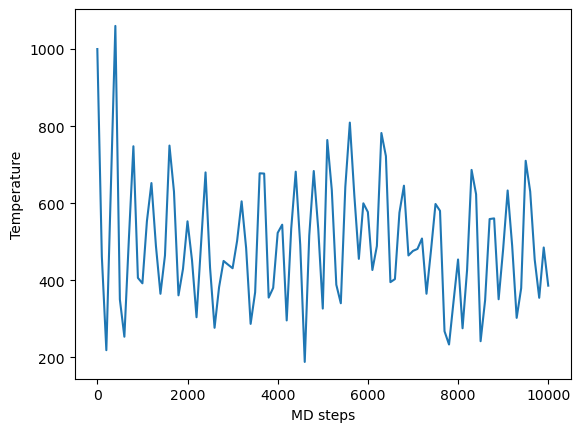

In [14]:
import matplotlib.pyplot as plt
plt.plot(job_lmp["output/generic/steps"], job_lmp["output/generic/temperature"])
plt.xlabel("MD steps")
plt.ylabel("Temperature")

The md trajectories are not stored in the `SQL` database but instead in an `HDF5` file which is a hierachical file format optimised for large arrays like trajectories. The content of the `HDF5` files can be browsed in pyiron just like folders on the filesystem. The plot above can be recreated without accessing the calculation object directly from the `Project` object using the universal path `output/generic/steps` and adding the name of the job `lmp_md` in the beginning:

Text(0, 0.5, 'Temperature')

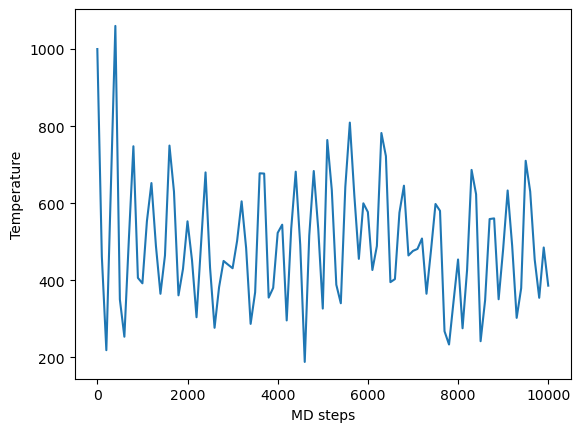

In [15]:
plt.plot(pr["lmp_md/output/generic/steps"], pr["lmp_md/output/generic/temperature"])
plt.xlabel("MD steps")
plt.ylabel("Temperature")

In addition to the temperature also the positions of the atomistic structure can be visualised. For example the `x-coordinate` over time. It is important to use the `unwrapped_positions` rather than the `positions` to prevent atoms to be mirrored from one periodic boundary to another:

Text(0, 0.5, 'Temperature')

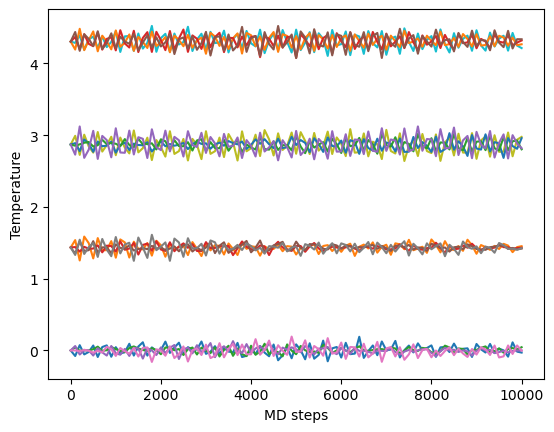

In [16]:
plt.plot(pr["lmp_md/output/generic/steps"], pr["lmp_md/output/generic/unwrapped_positions"][:,:,0])
plt.xlabel("MD steps")
plt.ylabel("Temperature")

Finally the molecular dynamics trajectory can be directly visualised in the browser: 

In [17]:
job_lmp.animate_structures()

NGLWidget(max_frame=100)

## Technical implementation 
The following section is designed to explain more details on the technical steps in the background. The understanding of the technical implementation is not required for all users but it can be helpful to debug failing calculation and get more insights in case something goes wrong, or in case the user wants to extend pyiron for their specific usecase.

Starting with the input of the simulation code, pyiron provides direct access to the underlying input files and the user can modify them interactively: 

In [18]:
job_lmp.input.control

,Parameter,Value,Comment
0,units,metal,
1,dimension,3,
2,boundary,p p p,
3,atom_style,atomic,
4,read_data,structure.inp,
5,include,potential.inp,
6,fix___ensemble,all nvt temp 500.0 500.0 0.1,
7,variable___dumptime,equal 100,
8,variable___thermotime,equal 100,
9,timestep,0.001,


In [19]:
job_lmp.input.control["run"] = 20000
job_lmp.input.control

/srv/conda/envs/notebook/lib/python3.11/site-packages/pyiron_base/storage/parameters.py:280: UserWarning: The input in GenericParameters changed, while the state of the job was already finished.
  warnings.warn(


,Parameter,Value,Comment
0,units,metal,
1,dimension,3,
2,boundary,p p p,
3,atom_style,atomic,
4,read_data,structure.inp,
5,include,potential.inp,
6,fix___ensemble,all nvt temp 500.0 500.0 0.1,
7,variable___dumptime,equal 100,
8,variable___thermotime,equal 100,
9,timestep,0.001,


pyiron warns the user that the calculation has already been executed and while it is possible to modify the input after the calculation it is not recommnded. To run the calculation again with the updated setting the `delete_existing_job=True` flag is used in the `run()` function:

In [20]:
job_lmp.run(delete_existing_job=True)

The job lmp_md was saved and received the ID: 1


In case the `delete_existing_job=True` flag is not set the calculation is not executed again, but instead the existing calculation is reloaded:

In [21]:
job_lmp.run()

2023-09-21 20:09:54,601 - pyiron_log - WARNING - The job lmp_md is being loaded instead of running. To re-run use the argument 'delete_existing_job=True in create_job'


In the background the `run()` function calls a shell script to call the simulation code. With this additional layer pyiron is able to support multiple version of the same executable: 

In [22]:
job_lmp.executable.list_executables()

['2020.03.03', '2020.03.03_mpi']

By default a serial executable is selected: 

In [23]:
job_lmp.executable

'/srv/conda/envs/notebook/share/pyiron/lammps/bin/run_lammps_2020.03.03.sh'

When the number of computing cores is increased the parallel executable is automatically selected during run time. Besides the cores also the `memory` and the `run_time` can be specified when submitting to a queuing system: 

In [24]:
# job_lmp.server.queue = "my_queue"
job_lmp.server.cores = 2
job_lmp.server.run_time = 100  # in sec. 

More detail on the queuing system configuration and different queuing systems which are supported is available in the [documentation](https://pyiron.readthedocs.io/en/latest/source/installation.html#remote-hpc-cluster). The executable in this example is a very simple shell script, but those scripts can be more extensive on an HPC cluster for example including the loading of modules or the setting of other environment variables. For more details on advanced executable configurations we refer to the [documentation](https://pyiron.readthedocs.io/en/latest/source/installation.html#use-your-own-executable-for-lammps-s-phi-nx-or-gpaw). 

In [25]:
!cat {job_lmp.executable}

#!/bin/bash
exec lmp_serial -in control.inp;


The executable is executed in the working directory which is generated based on the project path and the `job_name`:

In [26]:
job_lmp.working_directory

'/home/jovyan/demonstration/lmp_md_hdf5/lmp_md'

By default the output files are compressed after successful parsing and transfering of the intromation into the `HDF5` files. Still the archive can be decompressed to access additional outpus, for example for specific input commands:

In [27]:
import os
os.listdir(job_lmp.working_directory)

['lmp_md.tar.bz2']

In [28]:
job_lmp.decompress()
os.listdir(job_lmp.working_directory)

['control.inp',
 'structure.inp',
 'log.lammps',
 'dump.out',
 'potential.inp',
 'error.out',
 'Fe.eam.fs']

The content of the output files is again available using the edge braket notation: 

In [29]:
job_lmp["log.lammps"]

['LAMMPS (2 Aug 2023)\n',
 'units metal\n',
 'dimension 3\n',
 'boundary p p p\n',
 'atom_style atomic\n',
 'read_data structure.inp\n',
 'Reading data file ...\n',
 '  orthogonal box = (0 0 0) to (5.74 5.74 5.74)\n',
 '  1 by 1 by 1 MPI processor grid\n',
 '  reading atoms ...\n',
 '  16 atoms\n',
 '  read_data CPU = 0.000 seconds\n',
 'include potential.inp\n',
 'pair_style eam/fs\n',
 'pair_coeff * * Fe.eam.fs Fe\n',
 'fix ensemble all nvt temp 500.0 500.0 0.1\n',
 'variable dumptime  equal 100\n',
 'variable thermotime  equal 100\n',
 'timestep 0.001\n',
 'velocity all create 1000.0 86897 dist gaussian\n',
 'dump 1 all custom ${dumptime} dump.out id type xsu ysu zsu fx fy fz vx vy vz\n',
 'dump 1 all custom 100 dump.out id type xsu ysu zsu fx fy fz vx vy vz\n',
 'dump_modify 1 sort id format line "%d %d %20.15g %20.15g %20.15g %20.15g %20.15g %20.15g %20.15g %20.15g %20.15g"\n',
 'thermo_style custom step temp pe etotal pxx pxy pxz pyy pyz pzz vol\n',
 'thermo_modify format float %

By being able to add additional input commands and manually parse the output, pyiron can be easily extended to support additional features which are implemented in the simulation code but which are not yet available in the pyiron interface.

## Density functional theory
After the general introduction to molecular dynamics calculation with pyiron, the interface for DFT codes is briefly introduced. For comparison the energy volume curve is calculated for GPAW and S/PHI/nX in comparison to an interatomic potential calculation with LAMMPS. Starting with importing `numpy`: 

In [30]:
import numpy as np

Accessing the experimental reference data from `ASE` for an initial guess: 

In [31]:
from ase.data import reference_states, atomic_numbers
alat_guess = reference_states[atomic_numbers["Fe"]]["a"]  # guess for the expermential lattice constant
alat_guess

2.87

Creating a `for-loop` to iterate over the available simulation codes - in this test environment `LAMMPS`, `GPAW` and `S/PHI/nX` are available:

In [32]:
code_lst = ["Lammps", "Gpaw", "Sphinx"]

Then for each code calculate 11 strains ranging from 90% to 110%: 

In [33]:
for job_type in code_lst:
    for strain in np.linspace(0.9, 1.1, 11):
        job_name = "job_" + job_type.lower() + "_" + str(strain).replace(".", "_")
        job = pr.create_job(job_type=job_type, job_name=job_name)
        job.structure = pr.create.structure.ase.bulk("Fe", a=alat_guess * strain**(1/3))
        job.run()

/srv/conda/envs/notebook/lib/python3.11/site-packages/pyiron_atomistics/lammps/base.py:294: UserWarning: No potential set via job.potential - use default potential, 1997--Ackland-G-J--Fe--LAMMPS--ipr1
  warnings.warn(


The job job_lammps_0_9 was saved and received the ID: 2


/srv/conda/envs/notebook/lib/python3.11/site-packages/pyiron_atomistics/lammps/base.py:294: UserWarning: No potential set via job.potential - use default potential, 1997--Ackland-G-J--Fe--LAMMPS--ipr1
  warnings.warn(


The job job_lammps_0_92 was saved and received the ID: 3


/srv/conda/envs/notebook/lib/python3.11/site-packages/pyiron_atomistics/lammps/base.py:294: UserWarning: No potential set via job.potential - use default potential, 1997--Ackland-G-J--Fe--LAMMPS--ipr1
  warnings.warn(


The job job_lammps_0_9400000000000001 was saved and received the ID: 4


/srv/conda/envs/notebook/lib/python3.11/site-packages/pyiron_atomistics/lammps/base.py:294: UserWarning: No potential set via job.potential - use default potential, 1997--Ackland-G-J--Fe--LAMMPS--ipr1
  warnings.warn(


The job job_lammps_0_9600000000000001 was saved and received the ID: 5


/srv/conda/envs/notebook/lib/python3.11/site-packages/pyiron_atomistics/lammps/base.py:294: UserWarning: No potential set via job.potential - use default potential, 1997--Ackland-G-J--Fe--LAMMPS--ipr1
  warnings.warn(


The job job_lammps_0_9800000000000001 was saved and received the ID: 6


/srv/conda/envs/notebook/lib/python3.11/site-packages/pyiron_atomistics/lammps/base.py:294: UserWarning: No potential set via job.potential - use default potential, 1997--Ackland-G-J--Fe--LAMMPS--ipr1
  warnings.warn(


The job job_lammps_1_0 was saved and received the ID: 7


/srv/conda/envs/notebook/lib/python3.11/site-packages/pyiron_atomistics/lammps/base.py:294: UserWarning: No potential set via job.potential - use default potential, 1997--Ackland-G-J--Fe--LAMMPS--ipr1
  warnings.warn(


The job job_lammps_1_02 was saved and received the ID: 8


/srv/conda/envs/notebook/lib/python3.11/site-packages/pyiron_atomistics/lammps/base.py:294: UserWarning: No potential set via job.potential - use default potential, 1997--Ackland-G-J--Fe--LAMMPS--ipr1
  warnings.warn(


The job job_lammps_1_04 was saved and received the ID: 9


/srv/conda/envs/notebook/lib/python3.11/site-packages/pyiron_atomistics/lammps/base.py:294: UserWarning: No potential set via job.potential - use default potential, 1997--Ackland-G-J--Fe--LAMMPS--ipr1
  warnings.warn(


The job job_lammps_1_06 was saved and received the ID: 10


/srv/conda/envs/notebook/lib/python3.11/site-packages/pyiron_atomistics/lammps/base.py:294: UserWarning: No potential set via job.potential - use default potential, 1997--Ackland-G-J--Fe--LAMMPS--ipr1
  warnings.warn(


The job job_lammps_1_08 was saved and received the ID: 11


/srv/conda/envs/notebook/lib/python3.11/site-packages/pyiron_atomistics/lammps/base.py:294: UserWarning: No potential set via job.potential - use default potential, 1997--Ackland-G-J--Fe--LAMMPS--ipr1
  warnings.warn(


The job job_lammps_1_1 was saved and received the ID: 12
The job job_gpaw_0_9 was saved and received the ID: 13
The job job_gpaw_0_92 was saved and received the ID: 14
The job job_gpaw_0_9400000000000001 was saved and received the ID: 15
The job job_gpaw_0_9600000000000001 was saved and received the ID: 16
The job job_gpaw_0_9800000000000001 was saved and received the ID: 17
The job job_gpaw_1_0 was saved and received the ID: 18
The job job_gpaw_1_02 was saved and received the ID: 19
The job job_gpaw_1_04 was saved and received the ID: 20
The job job_gpaw_1_06 was saved and received the ID: 21
The job job_gpaw_1_08 was saved and received the ID: 22
The job job_gpaw_1_1 was saved and received the ID: 23
The job job_sphinx_0_9 was saved and received the ID: 24
The job job_sphinx_0_92 was saved and received the ID: 25
The job job_sphinx_0_9400000000000001 was saved and received the ID: 26
The job job_sphinx_0_9600000000000001 was saved and received the ID: 27
The job job_sphinx_0_98000000

With the combination of two `for-loops` one over the simulation codes and one over the 11 strain values, a total of 33 calculation were calculated. The `job_table()` function can be used to get an overview of all calculation: 

In [34]:
pr.job_table()

,id,status,chemicalformula,job,subjob,projectpath,project,timestart,timestop,totalcputime,computer,hamilton,hamversion,parentid,masterid
0,1,finished,Fe16,lmp_md,/lmp_md,None,/home/jovyan/demonstration/,2023-09-21 20:09:53.441924,2023-09-21 20:09:54.539917,1.0,pyiron@jupyter-pyiron-2dsusmet-2drdm-2dworkshop-2dxewkt7st#1,Lammps,0.1,None,None
1,2,finished,Fe,job_lammps_0_9,/job_lammps_0_9,None,/home/jovyan/demonstration/,2023-09-21 20:09:55.616415,2023-09-21 20:09:56.365822,0.0,pyiron@jupyter-pyiron-2dsusmet-2drdm-2dworkshop-2dxewkt7st#1,Lammps,0.1,None,None
2,3,finished,Fe,job_lammps_0_92,/job_lammps_0_92,None,/home/jovyan/demonstration/,2023-09-21 20:09:56.716570,2023-09-21 20:09:57.148083,0.0,pyiron@jupyter-pyiron-2dsusmet-2drdm-2dworkshop-2dxewkt7st#1,Lammps,0.1,None,None
3,4,finished,Fe,job_lammps_0_9400000000000001,/job_lammps_0_9400000000000001,None,/home/jovyan/demonstration/,2023-09-21 20:09:57.408241,2023-09-21 20:09:58.009882,0.0,pyiron@jupyter-pyiron-2dsusmet-2drdm-2dworkshop-2dxewkt7st#1,Lammps,0.1,None,None
4,5,finished,Fe,job_lammps_0_9600000000000001,/job_lammps_0_9600000000000001,None,/home/jovyan/demonstration/,2023-09-21 20:09:58.475397,2023-09-21 20:09:58.869273,0.0,pyiron@jupyter-pyiron-2dsusmet-2drdm-2dworkshop-2dxewkt7st#1,Lammps,0.1,None,None
5,6,finished,Fe,job_lammps_0_9800000000000001,/job_lammps_0_9800000000000001,None,/home/jovyan/demonstration/,2023-09-21 20:09:59.114859,2023-09-21 20:09:59.598590,0.0,pyiron@jupyter-pyiron-2dsusmet-2drdm-2dworkshop-2dxewkt7st#1,Lammps,0.1,None,None
6,7,finished,Fe,job_lammps_1_0,/job_lammps_1_0,None,/home/jovyan/demonstration/,2023-09-21 20:09:59.749858,2023-09-21 20:10:00.041337,0.0,pyiron@jupyter-pyiron-2dsusmet-2drdm-2dworkshop-2dxewkt7st#1,Lammps,0.1,None,None
7,8,finished,Fe,job_lammps_1_02,/job_lammps_1_02,None,/home/jovyan/demonstration/,2023-09-21 20:10:00.284262,2023-09-21 20:10:00.623461,0.0,pyiron@jupyter-pyiron-2dsusmet-2drdm-2dworkshop-2dxewkt7st#1,Lammps,0.1,None,None
8,9,finished,Fe,job_lammps_1_04,/job_lammps_1_04,None,/home/jovyan/demonstration/,2023-09-21 20:10:00.860595,2023-09-21 20:10:01.357101,0.0,pyiron@jupyter-pyiron-2dsusmet-2drdm-2dworkshop-2dxewkt7st#1,Lammps,0.1,None,None
9,10,finished,Fe,job_lammps_1_06,/job_lammps_1_06,None,/home/jovyan/demonstration/,2023-09-21 20:10:01.542004,2023-09-21 20:10:01.951389,0.0,pyiron@jupyter-pyiron-2dsusmet-2drdm-2dworkshop-2dxewkt7st#1,Lammps,0.1,None,None


Still already with 10+ calculation it is no longer efficient to load each of the calculation in an python object and aggregate the data manually. Instead pyiron implements an `map-reduce` approach to aggregate data. Starting with a filter function to select which calculation should be considered: 

In [35]:
def filter_jobs(job): 
    return "job_" in job.job_name

Followed by three functions to extract the data from the individual calculations, namely the volume, the total energy and the simulation code used: 

In [36]:
def get_volume(job):
    return job["output/generic/volume"][-1]

In [37]:
def get_energy(job):
    return job["output/generic/energy_tot"][-1]

In [38]:
def get_job_type(job):
    return job.job_name.split("_")[1]

Then the `iterjobs()` function of the `Project` object can be used to iterate over all calculation in a given project and append the aggregated data to a list:

In [39]:
vol_lst, eng_lst, type_lst = [], [], []
for job in pr.iter_jobs(): 
    if filter_jobs(job): 
        vol_lst.append(get_volume(job))
        eng_lst.append(get_energy(job))
        type_lst.append(get_job_type(job))

  0%|          | 0/34 [00:00<?, ?it/s]

Finally from the three lists a `pandas` dataframe is created for further processing:

In [40]:
import pandas 
df = pandas.DataFrame({"volume": vol_lst, "energy": eng_lst, "code": type_lst})
df

,volume,energy,code
0,10.637956,-4.237523,lammps
1,10.874355,-4.269142,lammps
2,11.110754,-4.291747,lammps
3,11.347153,-4.306420,lammps
4,11.583552,-4.314162,lammps
5,11.819951,-4.315913,lammps
6,12.056351,-4.312422,lammps
7,12.292750,-4.304104,lammps
8,12.529149,-4.291307,lammps
9,12.765548,-4.274357,lammps


Alternatively to manually creating a for loop to iterate over a given set of calculations, pyiron also implements the pyiron table object, which behaves like a job object and can be submitted to a computing cluster to aggregate data thereL

In [41]:
table = pr.create.table()

Again the same functions are used and after assigning them the `run()` function is called to start the pyiron table object:

In [42]:
table.filter_function = filter_jobs
table.add["volume"] = get_volume
table.add["energy"] = get_energy
table.add["code"] = get_job_type
table.run()

The job table was saved and received the ID: 35


Loading and filtering jobs:   0%|          | 0/35 [00:00<?, ?it/s]

Processing jobs:   0%|          | 0/33 [00:00<?, ?it/s]

The pyiron table object creates a dataframe, just like the one created above: 

In [43]:
df_table = table.get_dataframe()
df_table

,job_id,volume,energy,code
0,2,10.637956,-4.237523,lammps
1,3,10.874355,-4.269142,lammps
2,4,11.110754,-4.291747,lammps
3,5,11.347153,-4.306420,lammps
4,6,11.583552,-4.314162,lammps
5,7,11.819951,-4.315913,lammps
6,8,12.056351,-4.312422,lammps
7,9,12.292750,-4.304104,lammps
8,10,12.529149,-4.291307,lammps
9,11,12.765548,-4.274357,lammps


Finally the pandas dataframe can be used in combination with `matplotlib` to plot the energy volume curves for the three different simulation codes:

Text(0, 0.5, 'rel. Energy')

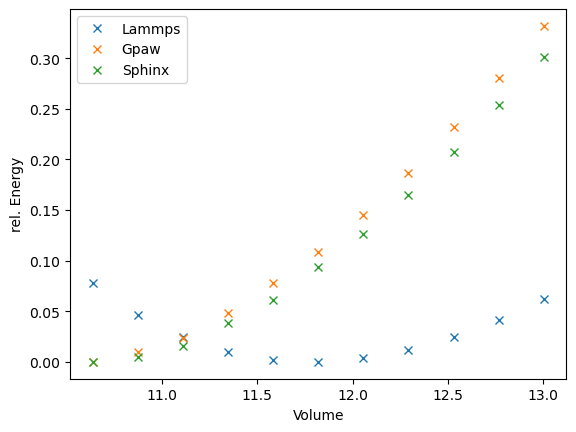

In [44]:
for code in code_lst: 
    df_tmp = df_table[df_table["code"] == code.lower()]
    plt.plot(df_tmp.volume, df_tmp.energy-df_tmp.energy.min(), "x", label=code)
plt.legend()
plt.xlabel("Volume")
plt.ylabel("rel. Energy")

## Additional tools

At the end of a workflow it is reasonable to collect the tools used in a given Project and publications to cite. In pyiron all publications for a given workflow can be listed usind the `list_publications()` function:

In [45]:
pr.list_publications()

,author,title,journal,volume,pages,issn,doi,url,year,number,publisher
0,"[Jan Janssen, Sudarsan Surendralal, Yury Lysogorskiy, Mira Todorova, Tilmann Hickel, Ralf Drautz, Jörg Neugebauer]",pyiron: An integrated development environment for computational materials science,Computational Materials Science,161,24 - 36,0927-0256,https://doi.org/10.1016/j.commatsci.2018.07.043,http://www.sciencedirect.com/science/article/pii/S0927025618304786,2019,NaN,NaN
1,"[Ask Hjorth Larsen, Jens Jørgen Mortensen, Jakob Blomqvist, Ivano E Castelli, Rune Christensen, Marcin Dułak, Jesper Friis, Michael N Groves, Bjørk Hammer, Cory Hargus, Eric D Hermes, Paul C Jenni...",The atomic simulation environment—a Python library for working with atoms,Journal of Physics: Condensed Matter,29,273002,NaN,NaN,http://stacks.iop.org/0953-8984/29/i=27/a=273002,2017,27,NaN
2,[Steve Plimpton],Fast Parallel Algorithms for Short-Range Molecular Dynamics,Journal of Computational Physics,117,1-19,0021-9991,10.1006/jcph.1995.1039,http://www.sciencedirect.com/science/article/pii/S002199918571039X,1995,1,NaN
3,"[G. J. Ackland, D. J. Bacon, A. F. Calder, T. Harry]",Computer simulation of point defect properties in dilute Fe-Cu alloy using a many-body interatomic potential,Philosophical Magazine A,75,713--732,NaN,10.1080/01418619708207198,https://doi.org/10.1080%2F01418619708207198,1997,3,Informa UK Limited


Another helpful function is the ability to remove all calculation in a given project. This can be done using the `remove_jobs()` function  which deletes all jobs in a given repository. By adding the parameter `silently` this can be done without the need for additional confirmation. This function should be used very carefully: 

In [46]:
# pr.remove_jobs(recursive=True)
pr.remove_jobs(recursive=True, silently=True)

  0%|          | 0/35 [00:00<?, ?it/s]

## Summary 
At the end of the first notebook the following features have been presented: 
* pyiron is designed to work with Jupyter notebooks and Jupyter Lab.
* The generic format allows the user to switch from one simulation code to the next. 
* Using the map-reduce principle pyiron is able to aggregate large amounts of data efficiently for further processing. 

Additional exercises: 
* Iterate over available interatomic potentials and calculate the energy volume curve for each of them. 
* Calculate the volume expansion for different using `calc_md()` with the additional `pressure=0.0` parameter for an NPT ensemble. An example for calculating the volume expansion is available in the [documentation](https://pyiron.readthedocs.io/en/latest/source/notebooks/first_steps.html)
* Use the functions `set_encut()` and `set_kpoints()` to modify the convergence parameters of a plane wave DFT code and study the convergence behaviour for calculating the energy volume curve. 